In [2]:
#importing the libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import random 
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm 
import cv2
from tensorflow import keras 
from tensorflow.keras import layers,models 
from keras_preprocessing.image import ImageDataGenerator 
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers.experimental import preprocessing
from pathlib import Path 
import os.path
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# import a series functions that are going to be use in our notebook
from HelperFunctions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [4]:
#loading our dataset from a local directory
dataset = r'../tochora/popd/movie dataset/dataset/'

here, we are going to create a dataFrame made up of two columns; 1 Filepath which shows diffrent paths of our classes/images and  Labels which classsify what type of identity is our image that is wheher it is a cabbage, chilli etc.

In [5]:
#
image_dir = Path(dataset)
#searching for files in our dataset that match labels like jpg, png etc and then making them a list
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r"**/*.jpg")) + list(image_dir.glob(r"**/*.png")) + list(image_dir.glob(r"**/*.PNG"))
# splitting and assighning each filepath a label
labels = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepaths))
# renaming our filepaths
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
# renaming our labels
labels = pd.Series(labels,name="Label")
#concatenating filepaths and labels into one dataframe
image_df = pd.concat([filepaths,labels],axis=1)
image_df.head()

,Filepath,Label
0,..\tochora\popd\movie dataset\dataset\cabbage\...,cabbage
1,..\tochora\popd\movie dataset\dataset\cabbage\...,cabbage
2,..\tochora\popd\movie dataset\dataset\cabbage\...,cabbage
3,..\tochora\popd\movie dataset\dataset\cabbage\...,cabbage
4,..\tochora\popd\movie dataset\dataset\cabbage\...,cabbage


Images visualization

Here we will visualize  a sample of images in our dataframe that is 16 images

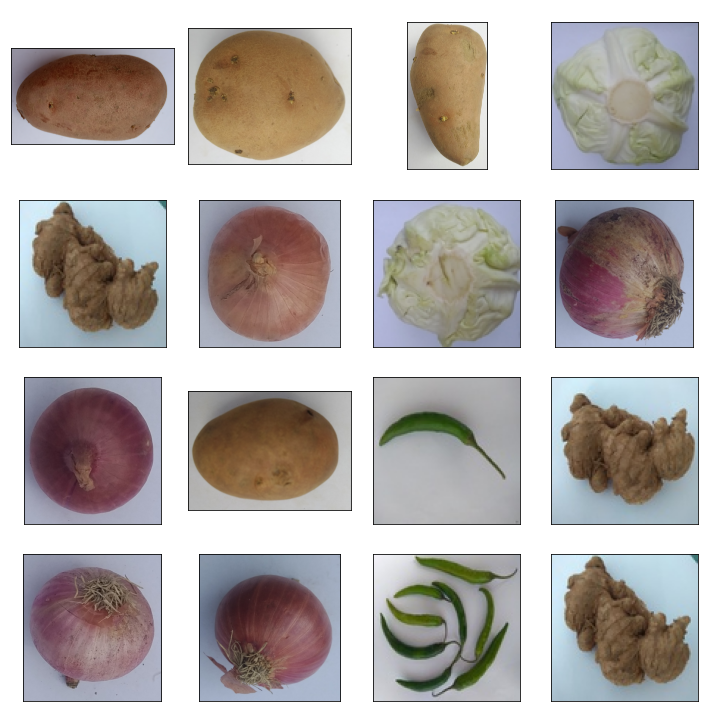

In [6]:
# random_index is made up of 16 images chosen randomly
random_index = np.random.randint(0, len(image_df), 16)
# specifying size and arguements of our figure
fig,axes = plt.subplots(4, 4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
# iterating simultaniously through each label and filepath
for i, ax in enumerate(axes.flat):
    #reading each image
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    # reading each image label
    ax.set_title(image_df.Label[random_index[i]], color='white')
plt.tight_layout()
plt.show()

Data preprocessing

Our data will be split into 3 diffrent classes that is training data for training our deep learning model, testig data for checking the preformanceof our model after validation data has fine-tuned the parameters in it.

In [7]:
#splitting our dataframe into test and traing data
train_df, test_df = train_test_split(image_df, test_size= 0.2, shuffle=True)

In [8]:
# normalizing our data
import tensorflow as tf
training_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

In [9]:
train_images = training_generator.flow_from_dataframe(dataframe= train_df, x_col = "Filepath", y_col = 'Label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = training_generator.flow_from_dataframe(dataframe= train_df, x_col = "Filepath", y_col = 'Label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation')
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col="Filepath", y_col='Label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False)


Found 1568 validated image filenames belonging to 5 classes.
Found 392 validated image filenames belonging to 5 classes.
Found 490 validated image filenames belonging to 5 classes.


applying diffrent transformations to images in our dataset;

In [10]:
resize_and_rescale = tf.keras.Sequential([
    # changing the dimensions of images height and width to 224
    layers.experimental.preprocessing.Resizing(224, 224),
    # rescalling images into [0, 255] range
    layers.experimental.preprocessing.Rescaling(1./255),
    # flipping the images horizontall during training
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    # rotating images by 0.1 degrees
    layers.experimental.preprocessing.RandomRotation(0.1),
    # zooming our images by 0.1 multiple
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1)
])

Transfer Learning

This is a machine learning technique where a pretrained model is re-used on a new problem by using the previous task as the starting point of the second problem.we will use EfficientnetBo model where:

include top = False to avoid using fully connected layer at the top of the network.

weights = imagenet that is using pretrained imagenet weights in our model

Input_shape specifies height, width and color channels

In [11]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top='False', weights='imagenet', pooling='max', input_shape=(224, 224, 3))
#freezing the layer sweight to updating them during training
pretrained_model.trainable = False

In [12]:
# creating a checkpoint callback
checkpoint_path = 'cabbage_classfication_model_checkpoint'
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor='val_accuracy', save_best_only=True)

In [13]:
# setting up ealystopping to stop training if model's val_loss doesn't reduce after 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Training our model

In [14]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(88, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(150, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
#
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# fitting our model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "cabbage_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/cabbage_classification/20230325-144921
Epoch 1/10
49/49 [==============================] - 271s 5s/step - loss: 1.5991 - accuracy: 0.3699 - val_loss: 1.5848 - val_accuracy: 0.6020
Epoch 2/10
49/49 [==============================] - 223s 5s/step - loss: 1.5777 - accuracy: 0.5370 - val_loss: 1.5571 - val_accuracy: 0.5765
Epoch 3/10
49/49 [==============================] - 210s 4s/step - loss: 1.5479 - accuracy: 0.5625 - val_loss: 1.5175 - val_accuracy: 0.5561
Epoch 4/10
49/49 [==============================] - 271s 6s/step - loss: 1.5047 - accuracy: 0.5670 - val_loss: 1.4620 - val_accuracy: 0.5714
Epoch 5/10
49/49 [==============================] - 255s 5s/step - loss: 1.4456 - accuracy: 0.5912 - val_loss: 1.3889 - val_accuracy: 0.5689
Epoch 6/10
49/49 [==============================] - 248s 5s/step - loss: 1.3719 - accuracy: 0.6161 - val_loss: 1.2968 - val_accuracy: 0.6250
Epoch 7/10
49/49 [==============================] - 225s 5s/step - l

Visualizing model performance on various metrics that is loss, val_loss, val_accuracy and accuracy

Text(0.5, 1.0, 'Model performance plot')

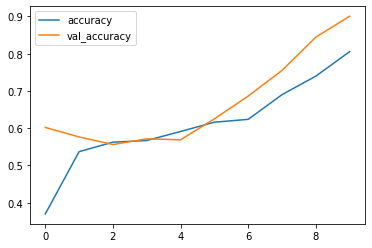

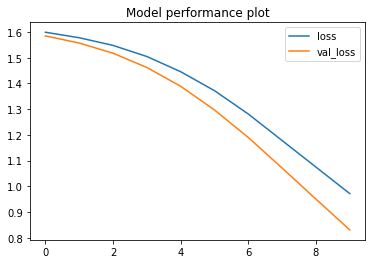

In [16]:
# plotting model performance
history = pd.DataFrame(history.history)
history[['accuracy', 'val_accuracy']].plot()
history[['loss', 'val_loss']].plot()
plt.title("Model performance plot", fontdict={"weight": 200, "color": "black"})

Making predictions using our model

In [21]:
# predicting label of the test images
pred = model.predict(test_images)
# returning indices of predicted images
pred = np.argmax(pred, axis=1)
#map the label
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred1 = [labels[k] for k in pred]
# displaying the results
print(f'the first 5 predictions: {pred1[:5]}')

16/16 [==============================] - 49s 3s/step
the first 5 predictions: ['onion', 'onion', 'potato', 'ginger', 'chilli']


Displaying 15 random images with their labels

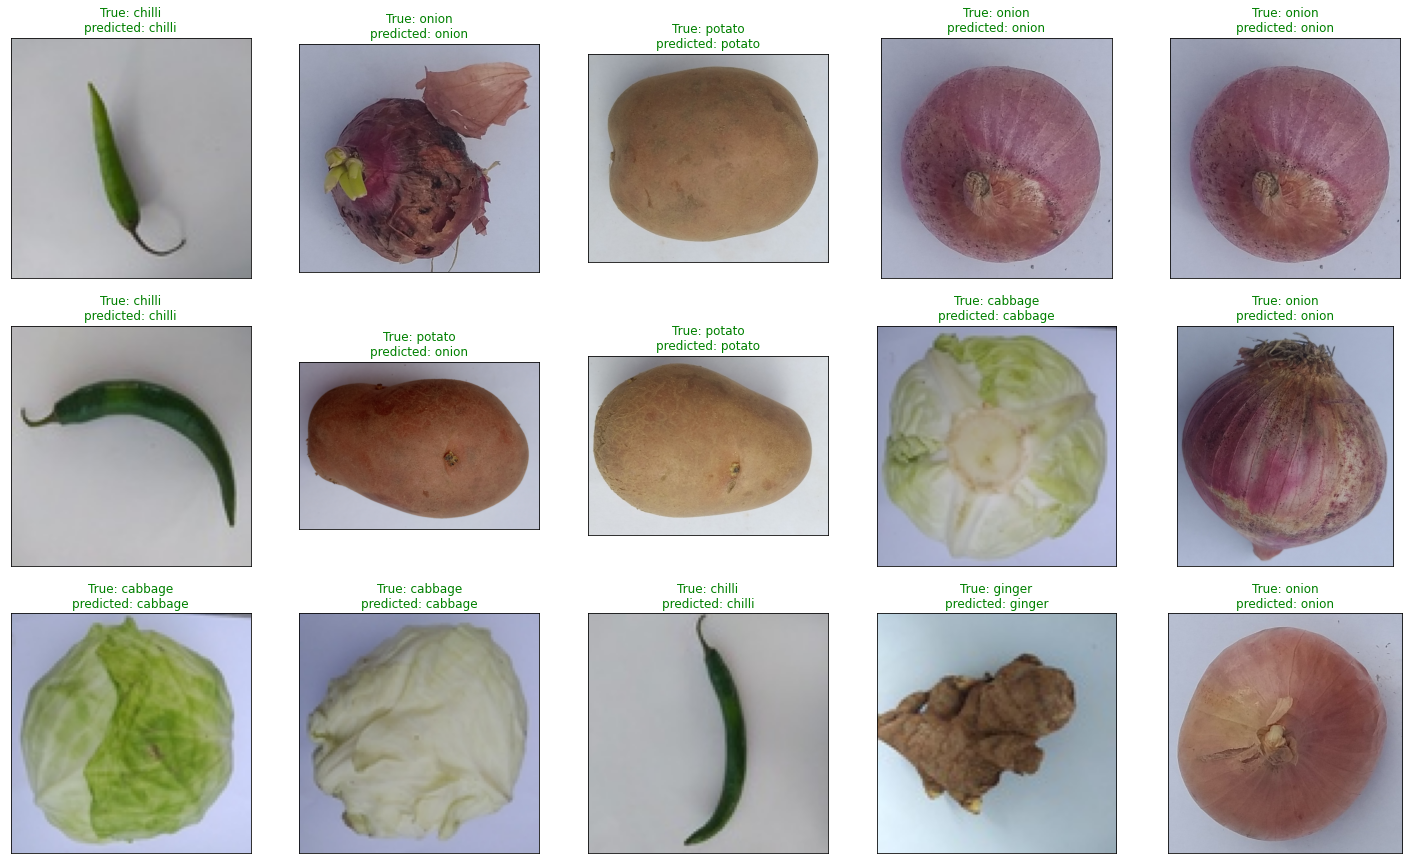

<Figure size 432x288 with 0 Axes>

In [26]:
# visualizing the predictions
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, subplot_kw= {"xticks": [], "yticks" : []}, figsize=(25, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = 'red'
    else:
        color = 'green'
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\npredicted: {pred1[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()